In [1]:
#including libraries
import numpy as np                          #scientific computing
from numpy.linalg import inv,det            # matrix operations
import numpy.random as ran 
import matplotlib.pyplot as plt             #plot library
import csv                                  #import csv data
import pandas as pd                         #import data
from scipy.io import loadmat                #import mat data
from sklearn.linear_model import LinearRegression

# Task 1. Poisson latent variable models.

In [2]:
# Import data

mat_file = loadmat('ex6file.mat')

# dynamic variables
u = mat_file["u"][:,:]    # 2x100 vector

# constants
A = mat_file["A"][:,:]                # 2x2 matrix
B = mat_file["B"][:,:]                # 2x2 matrix   
Gamma = mat_file["Gamma"][:,:]        # 4x2 matrix for Poisson process
eta0 = mat_file["n0"][:,:]            # 4x1 vector for Poisson process
Sigma = mat_file["Sigma"][:,:]        # 2x2 covariance matrix for Latent process 
mu0 = mat_file["mu0"][:,:]            # 2x1 vector for initial condition

print(u.shape)

(2, 100)


## 1. Create time series of M x T (M = 2, T = 100) dimensional latent states Z = {$z_t$} (named ’z’), and N x T dimensional observations C = {$c_t$}

In [3]:
np.random.seed(1)

# parameters of TS

M = 2
N = 4
T = 100

# create latent state

z = np.zeros((M, T))

z[:,0] = np.random.multivariate_normal(mu0.reshape(-1), Sigma)   # initial condition

for t in range(1,T):
    z[:,t] = A@z[:,t-1] + B@u[:,t] + np.random.multivariate_normal([0, 0], Sigma)

    
# Now create poissonian process

c = np.zeros((N, T))     # vector of Poisson data
lam = np.zeros((N, T))   # vector of Poisson means
for t in range(T):
    lam[:,t] = np.exp(np.log(eta0).reshape(-1) + Gamma@z[:,t])   # mean at each time step
    c[:,t] = np.random.poisson(lam[:,t])                         # data at each time step


print(z.shape)
print(c.shape)

(2, 100)
(4, 100)


### Plot the results

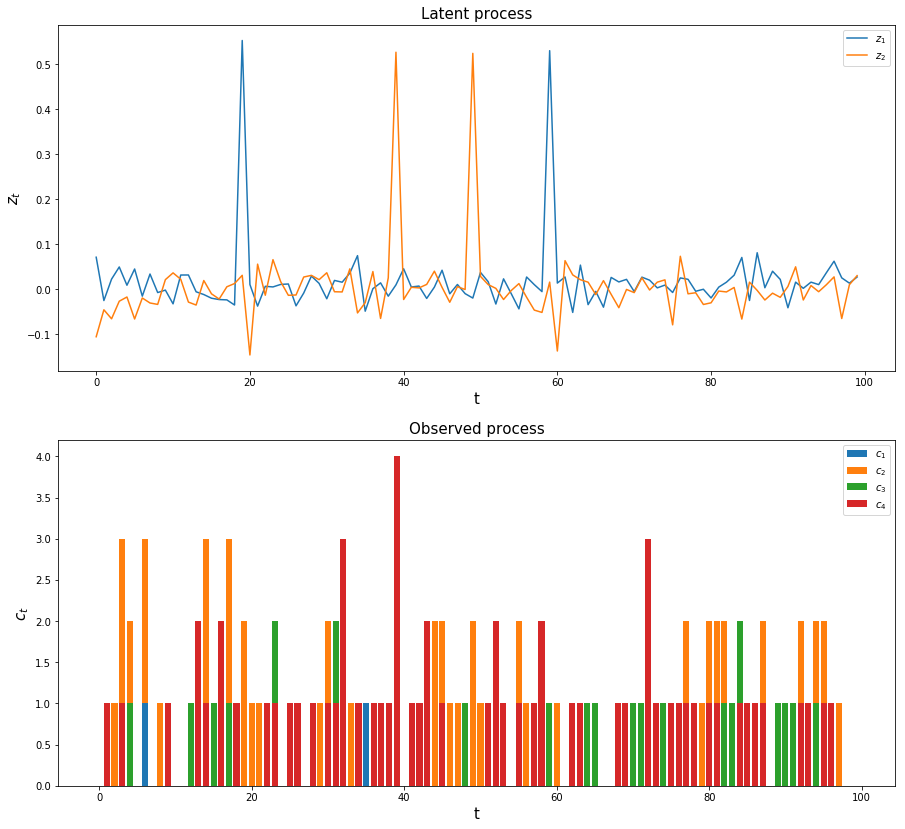

In [4]:
t = np.arange(T)

fig1 = plt.subplots(figsize=[15,14])

plt.subplot(2,1,1)
plt.plot(t, z[0,:], label = r'$z_1$')
plt.plot(t, z[1,:], label = r'$z_2$')
plt.title('Latent process', fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel('$z_t$', fontsize = 15)
plt.legend()

plt.subplot(2,1,2)
plt.bar(t, c[0,:], label = r'$c_1$', zorder=3)
plt.bar(t, c[1,:], label = r'$c_2$', zorder=0)
plt.bar(t, c[2,:], label = r'$c_3$', zorder=1)
plt.bar(t, c[3,:], label = r'$c_4$', zorder=2)
plt.title('Observed process', fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel('$c_t$', fontsize = 15)
plt.legend()

plt.show(fig1)

## 2. What is the joint data log-likelihood log p({$c_t ,z_t$}$|\theta$) of your generated time series?

To compute the joint data log-likelihood $log(p(\{c_t,z_t\}))$ we use Bayes' law:
$$log(p(\{c_t,z_t\})) = log(p(\{c_t\}|\{z_t\})) + log(p(\{z_t\}))$$
Thus we need to compute the log-likelihood for a Poissonian process and for a Gaussian one.

In [26]:
from scipy.special import factorial    # for factorial

def logl_joint(c, lam, z, A, B, mu0, sigma):
    
    # Poissonian part
    L_p = np.sum( np.sum( c*np.log(lam) - lam - np.log(factorial(c))))  # sum over data dimension and time
    print(L_p)
    
    # Gaussian part
    k = z.shape[0]
    T = z.shape[1]
    ll3 = -0.5*(np.dot(np.dot(np.transpose(z[:,0] - mu0.reshape(-1)), np.linalg.inv(sigma)), (z[:,0] - mu0.reshape(-1))))  # initial condition
    
    ll2 = 0.
    for i in range(T-1):
        ll2 += -0.5*(np.dot((np.dot(np.transpose(z[:,i+1] - A@z[:,i] - B@u[:,i+1]), np.linalg.inv(sigma))).reshape(1,-1), ((z[:,i+1] - A@z[:,i] - B@u[:,i+1]).reshape(-1,1))))
    print(ll2)
    
    print(k)
    ll2 += -0.5*( T*k*np.log(2*np.pi) + T*np.log(abs(np.linalg.det(sigma))) )
    print(ll2)
    print(ll3)
    
    return (L_p + ll2 + ll3)

In [27]:
print('\n \033[1m' + 'Joint Log-likelihood: ' + '\033[0m' + str(logl_joint(c, lam, z, A, B, mu0, Sigma)) )

-303.8772436918525
[[-82.45024755]]
2
[[424.53757371]]
-1.506371885048135

 Joint Log-likelihood: [[119.15395813]]


# Task 2. Fixed points, stability, and bifurcations.

Consider the univariate nonlinear map 
$$x_{t+1} = f(x_t,w,\theta) = w \cdot \sigma(x_t) + \theta $$
with $\sigma = \frac{1}{1+e^{-x}}$.

## 1. For w = 8 and  $\theta$= 3.5, find the fixed points of the system. Visualize these in a graph. 

In [7]:
# Define non-linear map

def f(x,w,theta):
    return w/(1+np.exp(-x)) + theta     # non-linear map

In [8]:
# Define function to find Fixed Points

def find_FP(x0, x1, f, w, theta, tol=1e-5):      # input: params, initial and final point of search
    
    epsilon = tol   # tolerance
    
    x = np.arange(x0, x1, 2*epsilon)    # vector of values to search
    
    bool = (abs(f(x, w, theta)-x)<epsilon)
    
    FP = x[bool]         # list of fixed points
            
    return FP    


 Fixed Points: [-3.18086 -0.52324  4.40328]


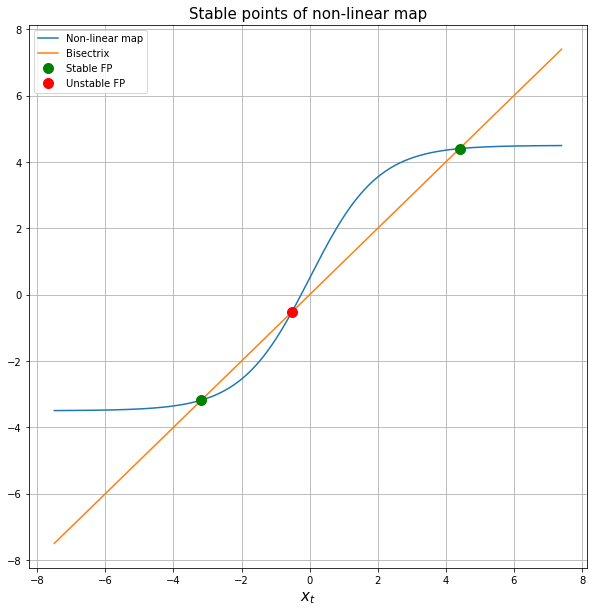

In [9]:
w, theta = 8, -3.5

FP = find_FP(-8, 8, f, w, theta)
print('\n \033[1m' + 'Fixed Points: ' + '\033[0m' + str(FP))

l = np.arange(-7.5,7.5, 0.1)

fig_FP = plt.figure(figsize=[10,10])
plt.plot(l, f(l,w,theta), label = 'Non-linear map')
plt.plot(l, l, label = 'Bisectrix')
plt.plot(FP[0], FP[0], 'go', label = 'Stable FP', markersize = 10)
plt.plot(FP[2], FP[2], 'go', markersize = 10)
plt.plot(FP[1], FP[1], 'ro', label = 'Unstable FP', markersize = 10)
plt.title('Stable points of non-linear map', fontsize=15)
plt.xlabel('$x_t$', fontsize=15)
plt.legend()
plt.grid()
plt.show(fig_FP)

### Are they stable?

comment ...

## 2. For w = 8, plot the bifurcation graph as a function of $\theta \in [-10, 0]$ . 

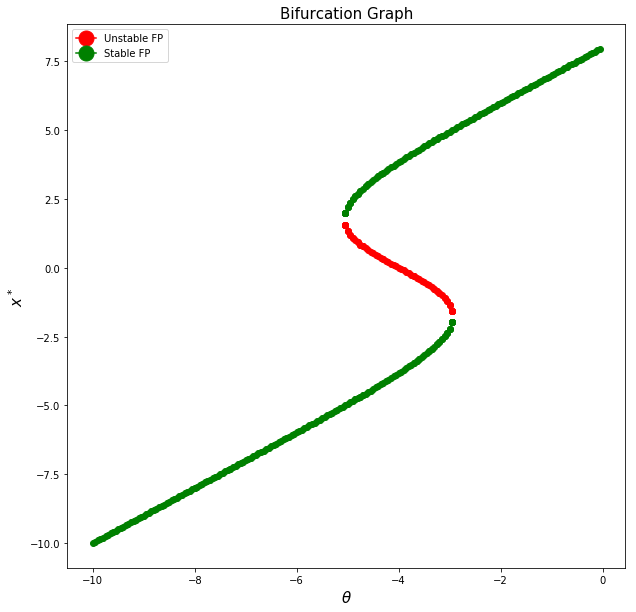

In [10]:
# now chage theta

theta = np.arange(-10, 0, 0.05)
dx = 0.01

fig_bif = plt.figure(figsize=[10,10])

for th in theta:
    FP = find_FP(th, 8, f, w, th)
    for i in range(len(FP)):
        if (f(FP[i]+dx, w, th)>FP[i]+dx):
            plt.plot(th, FP[i], 'ro')
        else:
            plt.plot(th, FP[i], 'go')

plt.title('Bifurcation Graph', fontsize=15)
plt.xlabel(r'$\theta$', fontsize=15)
plt.ylabel(r'$x^*$', fontsize=15)

import matplotlib.lines as mlines
red_point = mlines.Line2D([],[],color='red', marker='o', markersize=15, label='Unstable FP')
green_point = mlines.Line2D([],[],color='green', marker='o', markersize=15, label='Stable FP')
plt.legend(handles=[red_point, green_point])

plt.show(fig_bif)

### How does the system change its dynamical properties as $\theta$ is varied within this range?

comment ... 

# Task 3. Nonlinear systems, oscillations, and chaos.

Consider the ’Ricker map’, with parameter r $\in \mathbb{R}$ , and variable $x_t \in \mathbb{R}$:
$$x_{t+1} = rx_t e^{-x_t}$$

## 1. What are the fixed point(s) of this map? How many are there?

solution .... 

## 2. Explore the behavior of the map for a few values r $\in$ [exp(1), ... ,exp(4)] and comment on the dynamics.

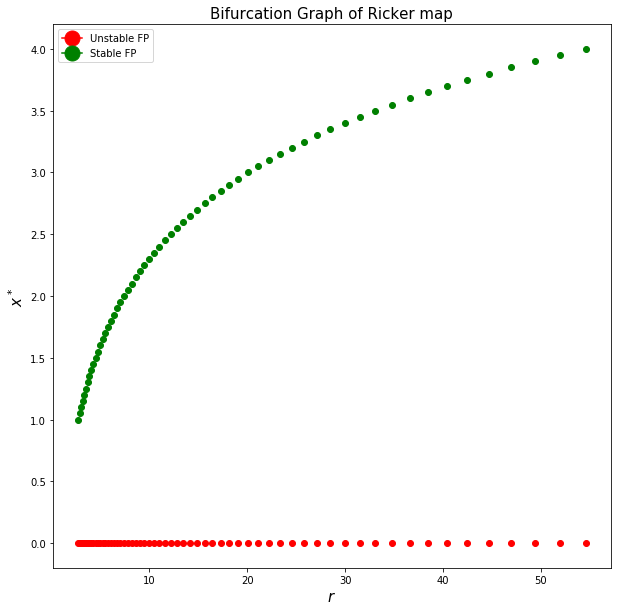

In [11]:
def ricker(x, r):
    return r*x*np.exp(-x)

log_r = np.arange(1, 4+0.05, 0.05)

fig_bif2 = plt.figure(figsize=[10,10])

for i in log_r:
    if (ricker(i+dx, np.exp(i))>i+dx):
        plt.plot(np.exp(i), i, 'ro')
        plt.plot(np.exp(i), 0, 'go')
    else:
        plt.plot(np.exp(i), i, 'go')
        plt.plot(np.exp(i), 0, 'ro')

plt.title('Bifurcation Graph of Ricker map', fontsize=15)
plt.xlabel(r'$r$', fontsize=15)
plt.ylabel(r'$x^*$', fontsize=15)

import matplotlib.lines as mlines
red_point = mlines.Line2D([],[],color='red', marker='o', markersize=15, label='Unstable FP')
green_point = mlines.Line2D([],[],color='green', marker='o', markersize=15, label='Stable FP')
plt.legend(handles=[red_point, green_point])

plt.show(fig_bif2)